# Goal: create a circular search polygon around a user defined geographic point coordinate with a given search radius in meters

**Input:** longitude and latitude of search center in decimal degrees and search radius in meters
* latitude  must be in decimal degrees and between ±90° latitude.
* longitude must be in decimal degrees degrees east and can be between 0° and 360° or ±180°
  Note: longitude will be wrapped to ±180°
  
**Output:** circular search polyon as GeoDataFrame and GeoJSON file

**Caveats:**
* crossing the poles at ±90° has not been tested and may produce unexpected results.
* crossing the prime meridian at ±180° has not been tested and may produce unexpected results.

In [1]:
# load required modules
import pyproj
import shapely
import numpy as np
#from functools import partial
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import transform
# the two lines before importing GeoPandas are to turn off a warning message and tell GeoPandas to use Shapely instead of PyGEOS
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from pyproj import Transformer

In [2]:
# get geographic point coordinates and search distance for spatial search
# user input
lat_ctr =  69.0285674715518
lon_ctr = -49.4797934493365
search_radius_m = 5000.0

# verify user input
if np.abs(lat_ctr) > 90:
    os.sys.exit("Center latitude for spatial search must be in decimal degress and between ±90°.")
if (lon_ctr < -180)  or (lon_ctr > 360):
    os.sys.exit("Center longitude for spatial search must be in decimal degress and between ±180° or 0° - 360° .")
    
# need to wrap longitudes to ±180° for exporting geographic coordinates. 0 to 360 is not supported
if np.abs(lon_ctr) > 180:
    lon_ctr = np.mod(lon_ctr - 180.0, 360.0) - 180.0

In [3]:
# define local stereographic projection with search coordinates as center in proj4 syntax
local_map_proj = "+proj=stere +lat_0={} +lat_ts={} +lon_0={} +x_0=0 +y_0=0 +units=m +datum=WGS84 +no_defs".format(lat_ctr, lat_ctr, lon_ctr)
print(f'local map projection used for buffer calculation:\n{local_map_proj}')

local map projection used for buffer calculation:
+proj=stere +lat_0=69.0285674715518 +lat_ts=69.0285674715518 +lon_0=-49.4797934493365 +x_0=0 +y_0=0 +units=m +datum=WGS84 +no_defs


In [4]:
# define local forward and inverse map projections
transformer_ll_to_xy = Transformer.from_crs("+proj=longlat +datum=WGS84 +no_defs",local_map_proj)
transformer_xy_to_ll = Transformer.from_crs(local_map_proj,"+proj=longlat +datum=WGS84 +no_defs")

In [5]:
# create circular polygon with desired search radius and transform back to geopgraphic coordinates
x_ctr, y_ctr = transformer_ll_to_xy.transform(float(lon_ctr), float(lat_ctr))
search_center_xy = Point(x_ctr, y_ctr)    # convert to shapely object for buffer calculation
search_buffer_xy = search_center_xy.buffer(search_radius_m)
# extract the vertices that define the perimeter of the search polygon b/c transformer does not take shapely objects as input
x_poly, y_poly = search_buffer_xy.exterior.coords.xy
lon_poly, lat_poly = transformer_xy_to_ll.transform(x_poly, y_poly)
# convert geographic search buffer vertices into a shapely polygon for GeoDataFrame
search_polygon_ll = Polygon(zip(lon_poly, lat_poly))

In [6]:
# create GeoDataFrame with coordinate reference system and geometry fields from search polygon
search_circle_gdf = gpd.GeoDataFrame(index = [0], crs = 'epsg:4326', geometry = [search_polygon_ll])

In [7]:
# save GeoJSON file
search_circle_gdf.to_file("search_circle_ll.geojson", driver="GeoJSON")  

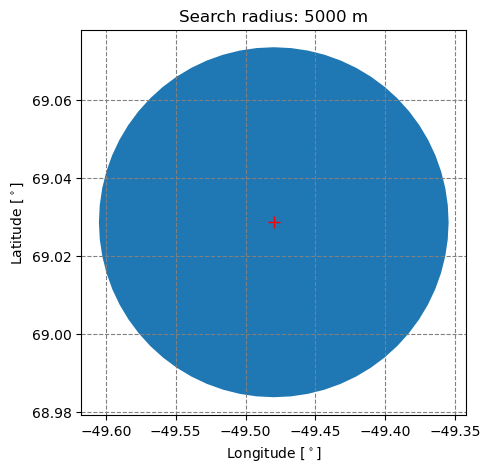

In [8]:
# make a simple plot of the search polygon in geopgraphical coordinates
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(5, 5))                    # create an empty Matplotlib figure with axes
search_circle_gdf.plot(ax=axs)                             # use pandas to plot the polygon on the existing figure
axs.plot(lon_ctr, lat_ctr, '+', markersize = 8,color = 'r', lw = 8, label='search center')
axs.set_ylabel("Latitude [$^\circ$]")                      # customize plot
axs.set_xlabel("Longitude [$^\circ$]")
axs.grid(True)
axs.grid(color='gray', linestyle='--', linewidth=0.80)
axs.set_title(f"Search radius: {search_radius_m:.0f} m")
fig.savefig("search_polygon_map.png")                      # save the figure
plt.show()                                                 # display plot

In [9]:
# plot search polygon with OpenStreetMap as basemap
search_circle_gdf.explore()